In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import rubin_sim.maf as maf
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.site_models import ScheduledDowntimeData, UnscheduledDowntimeData, UnscheduledDowntimeMoreY1Data, CloudData
from rubin_scheduler.site_models import CloudModel
from rubin_scheduler.utils import SURVEY_START_MJD
from rubin_sim.data import get_baseline

In [2]:
# Point to your baseline_v3.6 simulation
#opsdb = '../fbs_3.5/baseline_v3.5_10yrs.db'
opsdb = get_baseline()
run_name = os.path.split(opsdb)[-1].replace('.db', '')
print(opsdb, run_name)

/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v4.0_10yrs.db baseline_v4.0_10yrs


In [3]:
conn = sqlite3.connect(opsdb)
query = "select observationStartMJD, flush_by_mjd, night, visitExposureTime, visitTime, filter, slewTime, scheduler_note from observations"
visits = pd.read_sql(query, conn)

In [4]:
visit_counts = (
     visits.groupby(["night", "filter"])
     .count()
     .iloc[:, 0]
     .rename("count")
     .reset_index()
     .pivot(index=["filter"], columns=["night"], values="count")
     .fillna(0)
     .astype(int)
)
visit_counts

night,0,1,2,3,4,5,6,7,8,9,...,3642,3643,3644,3645,3647,3648,3649,3650,3651,3652
filter,,,,,,,,,,,,,,,,,,,,,
g,306,311,393,408,408,357,255,0,0,102,...,0,0,0,10,51,102,51,51,265,204
i,0,113,72,21,156,122,91,44,51,51,...,123,72,204,221,248,255,192,77,213,324
r,106,43,23,408,404,482,306,20,119,102,...,0,0,0,55,153,306,180,51,373,306
u,204,309,357,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
y,0,0,0,153,74,42,255,63,589,550,...,610,675,463,368,315,87,0,0,18,0
z,0,84,21,21,0,0,108,67,306,124,...,248,248,370,325,220,269,77,46,120,203


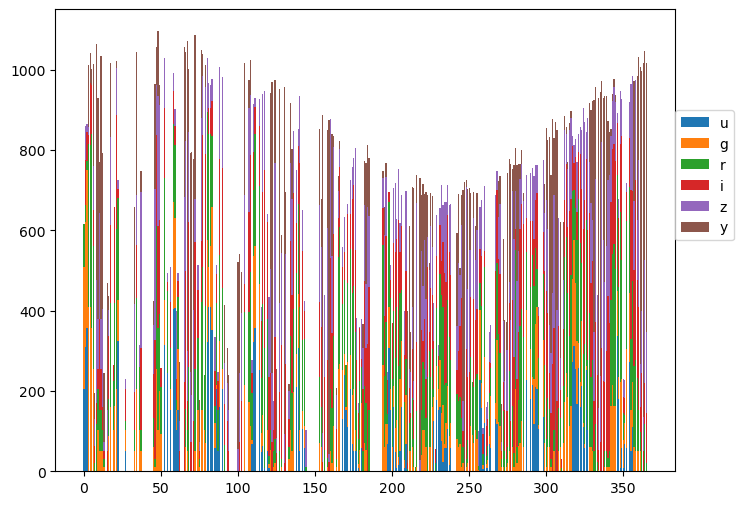

In [5]:
# Plot visits within first year to see ramp-up of visit acquisition
q = visit_counts.loc[:, 0:365]
base = np.zeros(q.columns.size)
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.bar(q.columns, q.loc[f], bottom=base, label=f)
    base += q.loc[f]
plt.legend(loc=(1.0, 0.5))

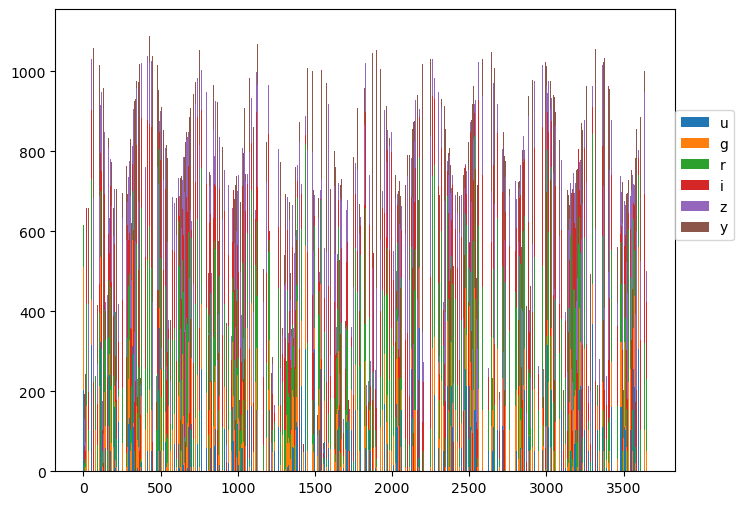

In [6]:
# Plot all years
q = visit_counts
base = np.zeros(q.columns.size)
plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.bar(q.columns, q.loc[f], bottom=base, label=f)
    base += q.loc[f]
plt.legend(loc=(1.0, 0.5))

In [19]:
start_mjd = np.floor(visits.observationStartMJD.min())
start_time = Time(start_mjd, format='mjd', scale='utc')
start_offset = start_time - Time('2025-01-01') - TimeDelta(0.34, format='jd')
start_mjd, start_time.iso

(60796.0, '2025-05-01 00:00:00.000')

In [20]:
almanac = Almanac(start_mjd)

In [21]:
start_idx = np.where(almanac.sunsets['night'] == 0)[0][0]

In [22]:
sunsets = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_setting']
sunrises = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_rising']

nights = np.arange(0, 3651, 1)
night_hours = (sunrises - sunsets) * 24
print(len(nights), len(sunsets))

3651 3651


In [23]:
sunsets = almanac.sunsets[start_idx : start_idx + 3651]['sun_n18_setting']
sunrises = almanac.sunsets[start_idx : start_idx + 3651]['sun_n18_rising']
night18_hours = (sunrises - sunsets) * 24

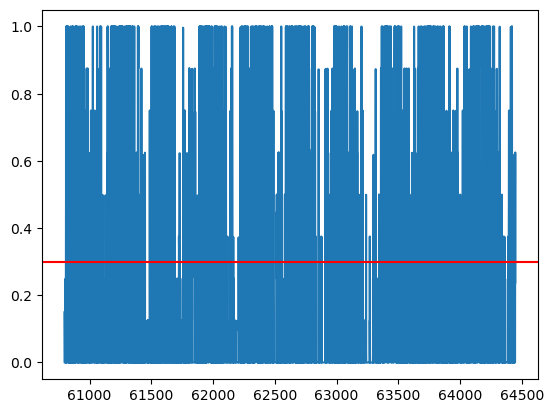

In [24]:
cloud_data = CloudData(start_time, scale=1)

sunsets = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_setting']
sunrises = almanac.sunsets[start_idx : start_idx + 3651]['sun_n12_rising']

stepsize = 5/60/24.0  # stepsize in days
years10 = np.arange(sunsets[0], sunrises[-1] + stepsize/2., stepsize)
year_mask = np.zeros(len(years10))

                        
for i, (s, r) in enumerate(zip(sunsets, sunrises)):
    nn = np.where((years10 >= s) & (years10 <=r), 1, 0)
    year_mask += nn

x = (years10 - cloud_data.start_time.mjd) * 24 * 60 * 60.
cloud_cover = np.interp(x, cloud_data.cloud_dates, cloud_data.cloud_values)
plt.plot(years10, cloud_cover)
cloud_limit = 0.3
plt.axhline(cloud_limit, color='r')

cloud_down_mask = np.where(cloud_cover >= cloud_limit, 0, 1)

In [25]:
scheduled_downtime = ScheduledDowntimeData(start_time)()

if 'v3.5' in run_name:
    unscheduled_downtime = UnscheduledDowntimeData(start_time)()
else:
    unscheduled_downtime =  UnscheduledDowntimeMoreY1Data(start_time)()


In [26]:
for d in scheduled_downtime:
    print(d['start'].iso, d['end'] - d['start'], d['activity'])

2025-06-07 15:50:24.000 7.0 general maintenance
2025-11-03 15:50:24.000 7.0 general maintenance
2026-06-07 15:50:24.000 7.0 general maintenance
2026-11-03 15:50:24.000 7.0 general maintenance
2027-06-07 15:50:24.000 14.0 recoat mirror
2028-06-06 15:50:24.000 7.0 general maintenance
2028-11-02 15:50:24.000 7.0 general maintenance
2029-06-06 15:50:24.000 14.0 recoat mirror
2030-06-06 15:50:24.000 7.0 general maintenance
2030-11-02 15:50:24.000 7.0 general maintenance
2031-06-06 15:50:24.000 14.0 recoat mirror
2032-06-05 15:50:24.000 7.0 general maintenance
2032-11-01 15:50:24.000 7.0 general maintenance
2033-06-05 15:50:24.000 14.0 recoat mirror
2034-06-05 15:50:24.000 7.0 general maintenance
2034-11-01 15:50:24.000 7.0 general maintenance
2035-06-05 15:50:24.000 14.0 recoat mirror
2036-06-04 15:50:24.000 7.0 general maintenance
2036-10-31 15:50:24.000 7.0 general maintenance
2037-06-04 15:50:24.000 14.0 recoat mirror
2038-06-04 15:50:24.000 7.0 general maintenance
2038-10-31 15:50:24.00

In [27]:
unscheduled_downtime[0:10]

array([(<Time object: scale='tai' format='isot' value=2025-01-29T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-01-30T15:50:24.000>, 'minor event'),
       (<Time object: scale='tai' format='isot' value=2025-02-03T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-02-06T15:50:24.000>, 'intermediate event'),
       (<Time object: scale='tai' format='isot' value=2025-03-02T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-03-09T15:50:24.000>, 'major event'),
       (<Time object: scale='tai' format='isot' value=2025-04-02T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-04-03T15:50:24.000>, 'minor event'),
       (<Time object: scale='tai' format='isot' value=2025-04-07T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-04-08T15:50:24.000>, 'minor event'),
       (<Time object: scale='tai' format='isot' value=2025-04-24T15:50:24.000>, <Time object: scale='tai' format='isot' value=2025-04-25T15:50:24.000>, '

Text(0, 0.5, 'Days of downtime')

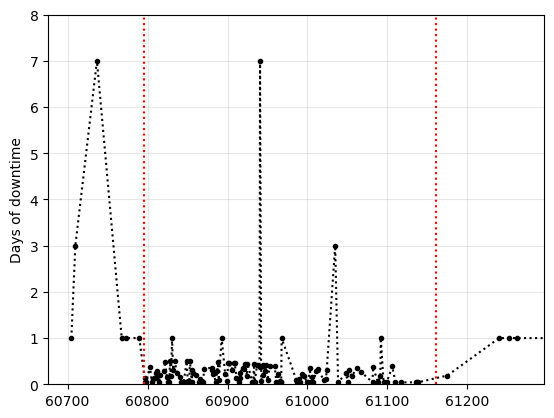

In [28]:
# Looking for a short downtime example, and checking on other things -- just convert unscheduled downtimes in pandas
udt = pd.DataFrame([[t.mjd for t in unscheduled_downtime['start']], 
                    [t.mjd for t in unscheduled_downtime['end']], 
                    unscheduled_downtime['activity']], 
                   index=["start", "end", "activity"]).T
udt['duration'] = udt['end'] - udt['start']
sunsets = []
sunrises = []
for i, row in udt.iterrows():
    ss = almanac.get_sunset_info(row['start'])
    sunrises.append(ss['sun_n12_rising'])
    sunsets.append(ss['sun_n12_setting'])
udt['sunrise'] = np.array(sunrises)
udt['sunset'] = np.array(sunsets)
#note that unscheduled downtime starts at the start of the year (as in UnscheduledDowntimeMoreYear1Data.t_start)
plt.plot(udt.start, udt.duration, 'k', marker='.', linestyle=':')
plt.axvline(start_mjd, color='r', linestyle=':')
plt.axvline(start_mjd + 365.25, color='r', linestyle=':')
plt.xlim(60675.66, start_mjd + 500)
plt.ylim(0, 8)
plt.grid(True, alpha=0.3)
plt.ylabel("Days of downtime")
# GOOD - looks like even with 'night0' being the start of the year, the onset of short downtimes is correct, and they last throughout the year.

In [29]:
udt.query("start > @start_mjd and start < @start_mjd + 400")

,start,end,activity,duration,sunrise,sunset
6,60796.204147,60796.340945,Year1 Eng,0.136798,60796.430025,60795.959207
7,60797.076465,60797.118132,Year1 Eng,0.041667,60797.430414,60796.958660
8,60798.149565,60798.191231,Year1 Eng,0.041667,60798.430802,60797.958125
9,60802.987666,60803.369368,Year1 Eng,0.381702,60803.432730,60802.955644
10,60805.265965,60805.307632,Year1 Eng,0.041667,60805.433499,60804.954746
...,...,...,...,...,...,...
125,61116.36752,61116.409187,Year1 Eng,0.041667,61116.411506,61115.993482
126,61136.214086,61136.255753,Year1 Eng,0.041667,61136.420124,61135.976614
127,61137.327276,61137.368943,Year1 Eng,0.041667,61137.420526,61136.975818
128,61138.029471,61138.071138,Year1 Eng,0.041667,61138.420926,61137.975028


In [31]:
# What does the scheduler do around this short downtime?
# What time is sunrise on this night? 
udt_i = 10
mjd = udt.iloc[udt_i]['start']
sunsets = almanac.get_sunset_info(mjd)#sunsets[1]['sun_n12_rising']
sunrise = sunsets['sun_n12_rising']
print("sunset", sunsets['sun_n12_setting'], "sunrise", sunsets['sun_n12_rising'])
print("downtime start", udt.iloc[udt_i]['start'], "downtime end", udt.iloc[udt_i]["end"],
      "length", (udt.iloc[udt_i]['end'] - udt.iloc[udt_i]['start']) * 24 * 60, "(minutes)")
start_dt = udt.iloc[udt_i]['start'] - 5 / 60 /24
end_dt = udt.iloc[udt_i]['end'] + 5 / 60 / 24
visits.query('observationStartMJD > @start_dt and observationStartMJD < @end_dt')

sunset 60804.95474600792 sunrise 60805.43349879375
downtime start 60805.26596504449 downtime end 60805.307631711155 length 59.99999999650754 (minutes)


,observationStartMJD,flush_by_mjd,night,visitExposureTime,visitTime,filter,slewTime,scheduler_note
8328,60805.262939,60805.329416,9,29.2,33.6,y,47.579912,"pair_33, yy, a"
8329,60805.263386,60805.329416,9,29.2,33.6,y,5.085316,"pair_33, yy, a"
8330,60805.263833,60805.329416,9,29.2,33.6,y,4.973234,"pair_33, yy, a"
8331,60805.264279,60805.329416,9,29.2,33.6,y,4.951866,"pair_33, yy, a"
8332,60805.264727,60805.329416,9,29.2,33.6,y,5.123847,"pair_33, yy, a"
8333,60805.265173,60805.329416,9,29.2,33.6,y,4.933758,"pair_33, yy, a"
8334,60805.309068,60805.376280,9,29.2,33.6,i,124.098396,"pair_33, iz, a"
8335,60805.309521,60805.376280,9,29.2,33.6,i,5.567157,"pair_33, iz, a"
8336,60805.309964,60805.376280,9,29.2,33.6,i,4.601029,"pair_33, iz, a"
8337,60805.310406,60805.376280,9,29.2,33.6,i,4.628213,"pair_33, iz, a"


In [32]:
# check that visits resume after downtime .. if not, can check clouds
clouds = CloudData(start_time=Time(start_mjd, format='mjd', scale='utc'))
clouds(Time(np.arange(start_dt, sunrise, 10/60/24), scale='utc', format='mjd')).max()

0.0

In [33]:
# Let's look at downtime events:
# Assign downtime hours from scheduled and unscheduled downtime events
mjds = start_mjd + nights
scheddown_hours = np.zeros(len(nights))
for dt in scheduled_downtime:
    idxs = np.where((mjds > dt['start'].mjd) & (mjds < dt['end'].mjd))[0]
    scheddown_hours[idxs] = night_hours[idxs]

unscheddown_hours = np.zeros(len(nights))
for dt in unscheduled_downtime:
    idxs = np.where((mjds > dt['start'].mjd) & (mjds < dt['end'].mjd))[0]
    hours = (dt['end'].mjd - dt['start'].mjd) * 24
    for idx in idxs:
        if hours > night_hours[idx]:
            unscheddown_hours[idx] = night_hours[idx]
        else:
            unscheddown_hours[idx] = hours

# if unscheduled events overlap scheduled ones, use scheduled only
overlaps = np.where((unscheddown_hours > 0) & (scheddown_hours >0))[0]
unscheddown_hours[overlaps] = 0

In [34]:
# Total amount of engineering downtime (days)
scheddown_hours.sum()/10/7, unscheddown_hours.sum()/10/7

(21.888956465625338, 23.89843654227942)

In [35]:
# number of nights with any observations
len(visits.night.unique()),  visits.night.max(), len(visits.night.unique())/visits.night.max()

(2789, 3652, 0.7636911281489595)

<BarContainer object of 399 artists>

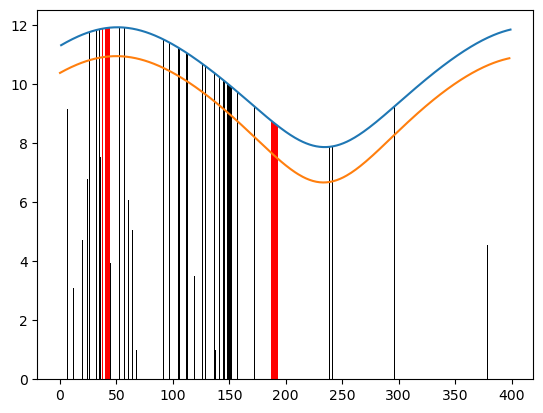

In [36]:
# First - just amount of downtime on any given night, compared to length of night
rr = np.where((nights > 0) & (nights < 400))
plt.plot(nights[rr], night_hours[rr], night18_hours[rr])
plt.bar(nights[rr], scheddown_hours[rr], color='r')
plt.bar(nights[rr], unscheddown_hours[rr], bottom=scheddown_hours[rr], color='k')

In [44]:
# Now let's calculate slewtime for all nights
yy = visits.query('night < @nights.max()')
slewtime = yy.groupby('night').sum('slewTime')['slewTime']/60/60
slewtime_hours = np.zeros(len(nights))
slewtime_hours[slewtime.index] = slewtime.values

In [45]:
# And calculate time in visits (including overhead)
visittime = yy.groupby('night').sum('visitTime')['visitTime']/60/60
visit_hours = np.zeros(len(nights))
visit_hours[visittime.index] = visittime.values

In [46]:
# And calculate open-shutter time
onsky_time = yy.groupby('night').sum('visitExposureTime')['visitExposureTime']/60/60
onsky_hours = np.zeros(len(nights))
onsky_hours[onsky_time.index] = onsky_time.values

# now can calculate overhead for each visit
visit_overhead = visit_hours - onsky_hours

In [47]:
# calculate actively observing hours
active_hours = slewtime_hours + visit_hours
# so downtime is time not actively observing -- due to scheduled, unscheduled and cloud downtime
down_hours = night_hours - active_hours
# we know downtime hours from scheduled and unscheduled -- assign what is left to clouds
# If the simulation is working properly, this is fine. Unexplained downtime will be assigned to clouds though, if it's not.
cloud_hours = down_hours - scheddown_hours - unscheddown_hours

In [55]:
# Look at the mean of some of these values. Note that this does include nights where we don't open at all.
np.mean(night_hours), np.mean(active_hours), np.mean(onsky_hours), np.mean(slewtime_hours), np.mean(scheddown_hours), np.mean(unscheddown_hours)

(10.057728257804692,
 6.544530568049468,
 4.685330061779116,
 1.2263173996633325,
 0.4196732272237123,
 0.45820064583937536)

In [56]:
# Hours total over the survey - convert to an easier sized unit
conversion = 1 / 8 / 7 # divide by 8 for a typical night then 7 for a typical week (this is 'survey weeks').
night_hours.sum() * conversion, cloud_hours.sum() * conversion, scheddown_hours.sum() * conversion, unscheddown_hours.sum() * conversion

(655.7279619508023, 171.8137009775535, 27.36119558203167, 29.873045677849273)

In [57]:
# what fraction of nights have some cloud down time
len(np.where(cloud_hours > 20/60)[0]) /  3651, 1 - (active_hours / night_hours).mean()

(0.34401533826348946, 0.3326704931399955)

In [58]:
# What fraction of the night, on average, are we observing
(onsky_hours / night_hours).mean(), (onsky_hours / night18_hours).mean()

(0.4775697826558655, 0.5350947341615414)

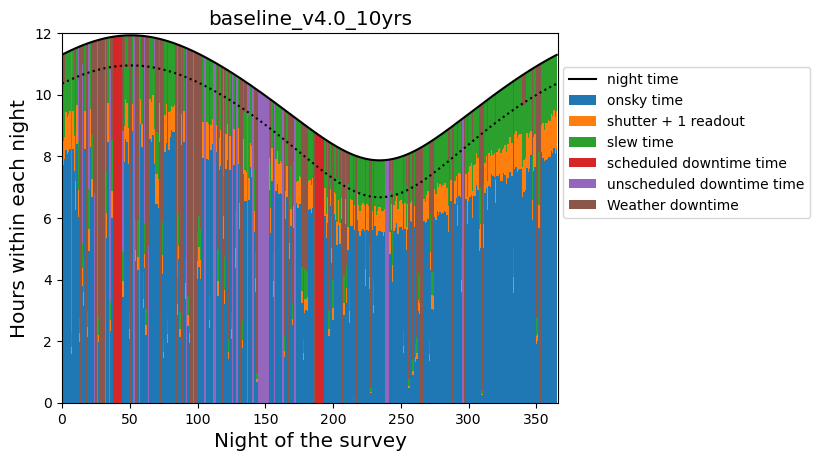

In [59]:
# Make plot of each of these contributions for the first 400 nights
# Remember downtime will be called "Weather" (clouds) if it's not explicitly due to other sources
start = 366*0
end = 366*1
rr = np.where((nights >= start) & (nights < end))
plt.plot(nights[rr], night_hours[rr], color='k', label='night time')
plt.plot(nights[rr], night18_hours[rr], color='k', linestyle=':')
base = 0
plt.bar(nights[rr], onsky_hours[rr], width=1, label='onsky time')
base = onsky_hours[rr] * 1
plt.bar(nights[rr], visit_overhead[rr], bottom=base, width=1, label='shutter + 1 readout')
base += visit_overhead[rr]
plt.bar(nights[rr], slewtime_hours[rr], bottom=base, width=1, label="slew time")
base += slewtime_hours[rr]
plt.bar(nights[rr], scheddown_hours[rr], bottom=base, width=1, label='scheduled downtime time')
base += scheddown_hours[rr]
plt.bar(nights[rr], unscheddown_hours[rr], bottom=base, width=1, label='unscheduled downtime time')
base += unscheddown_hours[rr]
plt.bar(nights[rr], cloud_hours[rr], bottom=base, width=1, label="Weather downtime")
plt.legend(loc=(1.01, 0.5))
plt.ylim(0, 12)
plt.xlim(start, end)
plt.xlabel("Night of the survey", fontsize='x-large')
plt.ylabel("Hours within each night", fontsize='x-large')
_ = plt.title(run_name, fontsize='x-large')
if 'v3.5' in run_name:
    plt.savefig('downtime_v3_5_year1.png', bbox_inches='tight')
else:
    plt.savefig('downtime_v4_0_year1.png', bbox_inches='tight')

Text(0, 0.5, 'Number of nights')

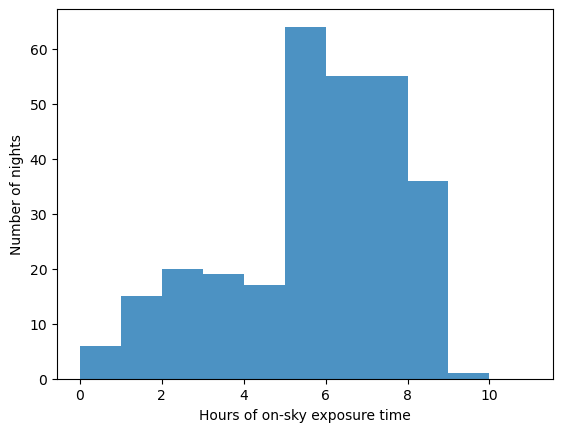

In [60]:
# Histogram of on-sky time in the first year
on_sky = onsky_hours[np.where(onsky_hours[rr] > 0)]
#_ = plt.hist(night_hours, bins=np.arange(0, 14, 0.5), histtype='step')
_ = plt.hist(on_sky, bins=np.arange(0, 12, 1), alpha=0.8)
plt.xlabel("Hours of on-sky exposure time")
plt.ylabel("Number of nights")

(0.0, 87.48067797419745)

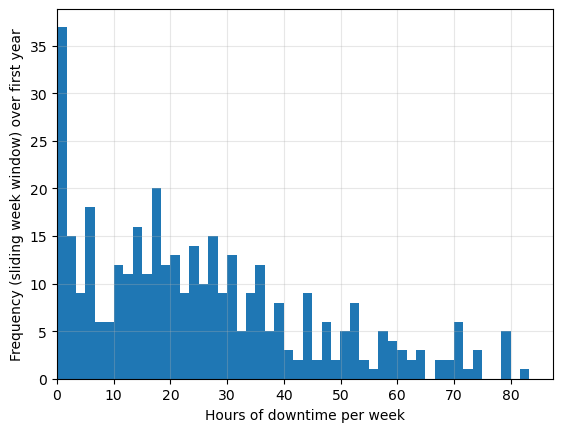

In [61]:
downtime_week = np.convolve(down_hours[rr], np.ones(7))
_ = plt.hist(downtime_week, bins=50)
plt.xlabel("Hours of downtime per week")
plt.ylabel("Frequency (sliding week window) over first year")
plt.grid(True, alpha=0.3)
plt.xlim(0)

(0.0, 390.6)

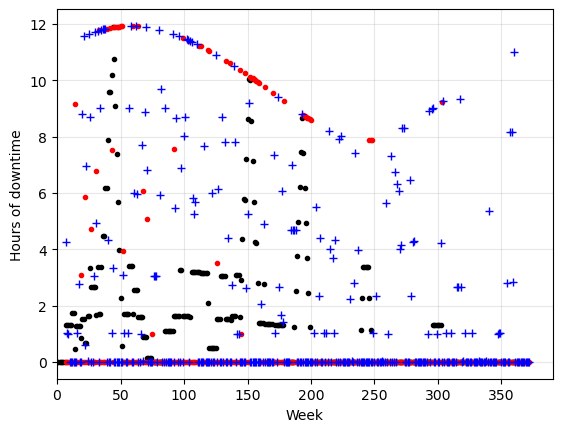

In [73]:
downtime_week = np.convolve((scheddown_hours[rr] + unscheddown_hours[rr]), np.ones(7)) / 7
plt.plot(np.arange(0, len(downtime_week)), downtime_week, 'k.')
plt.plot(rr[0]+7, (scheddown_hours[rr] + unscheddown_hours[rr]), 'r.')
plt.plot(rr[0]+7, cloud_hours[rr], 'b+')
plt.ylabel("Hours of downtime")
plt.xlabel("Week")
plt.grid(True, alpha=0.3)
plt.xlim(0)